In [381]:
import pandas as pd
import pickle
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
sns.set(font_scale = 1, style = 'darkgrid', rc={'figure.figsize':(7,5)})

Time periods:
1. Baseline period: 2005-2010
2. Intervention period: 2011-2019
3. Evaluation period: 2020-


1. Find the K nearest sponsoring units for each sponsoring unit for each year from 2005 to 2010(or other year)
    - Save distance
2. Sum distances, and find the K sponsoring units with smalles total distance
3. Calculate relative likelihood of unit inviting females, for each unit
4. Now find the sponsoring units that adopted different strategies from 2011 to 2020
    - Unit i have high likelihood of invited females, unit j have low likelihood of inviting females
        - Do this by finding units with large difference of likelihood
5. Increase in female attendees compare to baseline period
    - How is outcome for unit i vs unit j?

# Method

1. Remove sponsoring units that have data for less than 5 years. These are too small for us to see anything.
2. Remove sponsoring units with less than 3 years in baseline. These do not have enough data to compare with
3. Remove sponsoring units with 20 or less researchers from 2005 to 2019
4. remove sponsoring units that is not in the baseline data. This is because we don't have anything to compare with, if it is not in baseline

we try with baseline 2005-2013


As starting point, we only use units with data from the entire period


# Functions

In [2]:
#do some function where we calculate each feature
#def getFeatures(features):
#    if x in features:
#        #calcualte x
#    if i in feaures:
#        ##calculate i

In [363]:
def getFemaleRatio(sponsoringUnits, invited_df, attendees_df, unitCol):
    index = 0
    femaleRatioInv_dict = {}
    femaleRatioAtt_dict = {}
    for i in sponsoringUnits:
        sponsoringUnitInv = invited_df[invited_df[unitCol] == i]
        sponsoringUnitAtt = attendees_df[attendees_df[unitCol] == i]
        invited_crossTab = pd.crosstab(index = sponsoringUnitInv.Year, columns = sponsoringUnitInv.Gender,
                    normalize = "index")['Female'].reset_index().rename(columns = {'Female': 'FemaleRatio_inv'})
        invited_crossTab['SponsoringUnitName'] = i
    
        attendees_crossTab = pd.crosstab(index = sponsoringUnitAtt.Year, columns = sponsoringUnitAtt.Gender,
                    normalize = 'index')['Female'].reset_index().rename(columns = {'Female': 'FemaleRatio_att'})
    
        attendees_crossTab['SponsoringUnitName'] = i
    
        invitedDict = invited_crossTab.to_dict('list')
        attendeesDict = attendees_crossTab.to_dict('list')
        femaleRatioInv_dict[index] = invitedDict
        femaleRatioAtt_dict[index] = attendeesDict
        index += 1

    return femaleRatioInv_dict, femaleRatioAtt_dict

In [364]:
def standardizeColumn(df, columnName):
    standardizedColumn = (df[columnName] - df[columnName].mean())/(df[columnName].std())
    
    return standardizedColumn

In [365]:
def KNN(df, features, K):
    neighborDict = {}
    index = 0
    df_stand = df.copy()
    
    for c in features:
        df_stand[c] = standardizeColumn(df_stand, c) #standardize data
    
    years = df.Year.unique()
    for y in years:
        year_df = df_stand[df_stand.Year == y]
        
        #do KNN
        neighbors = NearestNeighbors(n_neighbors = K, metric = 'manhattan').fit(year_df[features])
        kNeighbor_dist, kNeighbor_ind = neighbors.kneighbors(year_df[features])
        
        unitOrder = year_df.SponsoringUnitName.values.tolist() #list of sponsoring unit(and order of it)
        for i in range(0,len(unitOrder)):
            for j in range(1, len(unitOrder)):
                neighborDict[index] = {'Year': y, 'SponsoringUnitName': unitOrder[i], 'Neighbors': unitOrder[kNeighbor_ind[i,j]], 'Distances': kNeighbor_dist[i,j]}
                index += 1
    return neighborDict

In [366]:
def findNearestNeighbors(df, K):
    kNeighborMatch = {}
    for i in sponsoringUnits:
        unit_df = df[df.SponsoringUnitName == i]
        nearestNeighbors = unit_df.nsmallest(K, 'Distances').Neighbors.tolist()
        kNeighborMatch[i] = nearestNeighbors
    
    neighbor_df = pd.DataFrame.from_dict(kNeighborMatch, orient = 'index')
    return neighbor_df

In [327]:
sponsUnitResearchers = pd.read_pickle("Files/Dataframes/researchers_sponsoringUnits.pkl")

In [24]:
#define invited speakers and attendees
invited = sponsUnitResearchers[sponsUnitResearchers.SessionType == 'invited']
attendees = sponsUnitResearchers[sponsUnitResearchers.SessionType == 'attendee']

In [31]:
#number of years with data for each sponsoring unit for invited speakers and attendees
invitedYearCount = invited.groupby(['SponsoringUnitName', 'Year']).count()['SearchName'].reset_index().groupby('SponsoringUnitName').count().reset_index()
attendeesYearCount = attendees.groupby(['SponsoringUnitName', 'Year']).count()['SearchName'].reset_index().groupby('SponsoringUnitName').count().reset_index()

In [39]:
yearCount_df = invitedYearCount[['SponsoringUnitName', 'Year']].rename(columns = {'Year': 'invitedYears'})
yearCount = yearCount_df.merge(attendeesYearCount[['SponsoringUnitName', 'Year']], how = 'outer', on = 'SponsoringUnitName').rename(columns = {'Year': 'attendeeYears'})

In [69]:
#units with data for all 19 years
units = yearCount[(yearCount.invitedYears == 19) & (yearCount.attendeeYears == 19)].SponsoringUnitName.tolist()

In [45]:
#number of years with data for each sponsoring unit
#yearCount = sponsUnitResearchers.groupby(['SponsoringUnitName', 'Year']).count()['SearchName'].reset_index().rename(columns = {'SearchName': 'UnitSize'}).groupby('SponsoringUnitName').count().reset_index()
#totalSize = sponsUnitResearchers.groupby(['SponsoringUnitName']).count()

In [70]:
#list of sponsoring units with at most data for four years + "None" as sponsoring units
#smallUnits = yearCount[yearCount.Year <= 4].SponsoringUnitName.tolist()
#smallUnits.append(totalSize[totalSize.SearchName <= 20].index.tolist()) #append units with 50 or less researchers
#smallUnits.append(None)

#only choose data for the chosen units
filteredData = sponsUnitResearchers[sponsUnitResearchers.SponsoringUnitName.isin(units)]

In [73]:
#data for 2013 or earlier
baselineData = filteredData[filteredData.Year <= 2013]
interventionData = filteredData[(filteredData.Year > 2013) & (filteredData.Year < 2020)]
evaluationData = filteredData[filteredData.Year >= 2020]

#count of number of years in baseine data for each sponsoring units
#baselineYearCount = baselineData.groupby(['SponsoringUnitName', 'Year']).count().reset_index().groupby('SponsoringUnitName').count()

#baselineUnits = baselineYearCount[baselineYearCount.Year >= 3].index.tolist()

In [48]:
#filter data by removing sponsoring units that were not in baseline data or should be removed
#removeUnits_filtering = filteredData[filteredData.SponsoringUnitName.isin(baselineUnits)]

In [10]:
#define baselineData(again), intrvention data and evaluation data
#baselineData = removeUnits_filtering[removeUnits_filtering.Year <= 2013]
#interventionData = removeUnits_filtering[(removeUnits_filtering.Year > 2013) & (removeUnits_filtering.Year < 2020)]
#evaluationData = removeUnits_filtering[removeUnits_filtering.Year >= 2020]

In [74]:
sizePerYear = baselineData.groupby(['SponsoringUnitName', 'Year']).count()['SearchName'].reset_index().rename(columns = {'SearchName': 'UnitSize'})

In [75]:
invitedBaseline = baselineData[baselineData.SessionType == 'invited']
attendeesBaseline  = baselineData[baselineData.SessionType == 'attendee']

In [76]:
invitedPerYear = invitedBaseline.groupby(['SponsoringUnitName', 'Year']).count()['SearchName'].reset_index().rename(columns = {'SearchName': 'n_invited'})
attendeesPerYear = attendeesBaseline.groupby(['SponsoringUnitName', 'Year']).count()['SearchName'].reset_index().rename(columns = {'SearchName': 'n_attendees'})

In [15]:
#count years with attendees per sponsoring unit
#attendeesYearCount = attendeesPerYear.groupby('SponsoringUnitName').count().reset_index()
#invitedYearCount = invitedPerYear.groupby('SponsoringUnitName').count().reset_index()

In [77]:
#create list of sponsoring units
#sponsoringUnits = units.SponsoringUnitName.tolist()
#units = attendeesYearCount[attendeesYearCount.Year == 6].SponsoringUnitName.tolist()

In [81]:
femaleInv, femaleAtt = getFemaleRatio(units, invitedBaseline, attendeesBaseline, 'SponsoringUnitName')

femaleRatio_inv = pd.DataFrame.from_dict(femaleInv, orient='index').explode(['Year', 'FemaleRatio_inv', 'SponsoringUnitName']).reset_index(drop = True)
femaleRatio_att = pd.DataFrame.from_dict(femaleAtt, orient='index').explode(['Year', 'FemaleRatio_att', 'SponsoringUnitName']).reset_index(drop = True) 

In [104]:
#add attributes
sponsorUnit_df = sizePerYear.merge(invitedPerYear, how = 'outer', on = ['SponsoringUnitName', 'Year'])
sponsorUnit_df = sponsorUnit_df.merge(attendeesPerYear, how = 'outer', on = ['SponsoringUnitName', 'Year'])
sponsorUnit_df = sponsorUnit_df.merge(femaleRatio_inv, how = 'outer', on = ['SponsoringUnitName', 'Year'])
sponsorUnit_df = sponsorUnit_df.merge(femaleRatio_att, how = 'outer', on = ['SponsoringUnitName', 'Year'])

In [54]:
#select units with data from 2005
#yearCountSponsUnit = sponsorUnit_df.groupby('SponsoringUnitName').count()
#selectedUnitsList = yearCountSponsUnit[yearCountSponsUnit.Year == 6].reset_index().SponsoringUnitName.tolist()

In [56]:
#remove those that don't have data for 2005-2010
#sponsorUnit_df = sponsorUnit_df[sponsorUnit_df.SponsoringUnitName.isin(selectedUnitsList)] 

In [233]:
#features = ['UnitSize', 'n_invited', 'n_attendees', 'FemaleRatio_inv', 'FemaleRatio_att']
features = ['n_invited', 'n_attendees', 'FemaleRatio_inv', 'FemaleRatio_att']
KNN_dict = KNN(sponsorUnit_df, features, len(units))

In [235]:
neighbor_df = pd.DataFrame.from_dict(KNN_dict , orient='index')

In [271]:
distanceSum = neighbor_df.groupby(['SponsoringUnitName', 'Neighbors']).sum().reset_index()

In [369]:
similarUnits = findNearestNeighbors(distanceSum, 4)

In [388]:
#load relative likelihood 
likelihood = pd.read_pickle("Files/Dataframes/sponsoringUnitsLikelihood.pkl")

In [403]:
#select data for sponsoring units in the list "sponsoringUnits"
likelihood_units = likelihood[likelihood.SponsoringUnit.isin(sponsoringUnits)]

In [404]:
#likelihood for intervention period
interventionLikelihood = likelihood_units[(likelihood_units.Year >= 2014) & (likelihood_units.Year <= 2019)]

In [406]:
#interventionLikelihood
#now for each similar units(index, column), calculate the difference of relative likelihood

,0,1,2,3
"Atomic, Molecular & Optical Physics",Instrument and Measurement Science,Computational Physics,Statistical and Nonlinear Physics,Chemical Physics
Chemical Physics,Statistical and Nonlinear Physics,Magnetism and its Applications,Industrial and Applied Physics,Computational Physics
Computational Physics,Magnetism and its Applications,Statistical and Nonlinear Physics,Industrial and Applied Physics,Chemical Physics
Condensed Matter Physics,Materials Physics,Magnetism and its Applications,Industrial and Applied Physics,Computational Physics
Fluid Dynamics,Statistical and Nonlinear Physics,Instrument and Measurement Science,Chemical Physics,Industrial and Applied Physics
Industrial and Applied Physics,Magnetism and its Applications,Chemical Physics,Computational Physics,Statistical and Nonlinear Physics
Instrument and Measurement Science,"Atomic, Molecular & Optical Physics",Statistical and Nonlinear Physics,Computational Physics,Chemical Physics
Magnetism and its Applications,Industrial and Applied Physics,Computational Physics,Chemical Physics,Statistical and Nonlinear Physics
Materials Physics,Condensed Matter Physics,Magnetism and its Applications,Industrial and Applied Physics,Polymer Physics
Polymer Physics,Chemical Physics,Magnetism and its Applications,Statistical and Nonlinear Physics,Industrial and Applied Physics


,K,Year,Avg_likelihood,STD_likelihood,SEM_likelihood,SponsoringUnit
0,50,2005,0.874115,0.473424,0.014971,Chemical Physics
1,50,2006,1.037063,0.520278,0.016453,Chemical Physics
2,50,2007,0.766307,0.350448,0.011082,Chemical Physics
3,50,2008,0.489664,0.346088,0.010944,Chemical Physics
4,50,2009,1.505976,0.710626,0.022472,Chemical Physics
...,...,...,...,...,...,...
14,50,2019,1.766446,0.510060,0.016130,Polymer Physics
15,50,2020,0.902848,0.249265,0.007882,Polymer Physics
16,50,2021,1.288245,0.388632,0.012290,Polymer Physics
17,50,2022,2.083468,0.805547,0.025474,Polymer Physics


In [ ]:
#for each sponsoring unit, calculate relative likelihood of inviting females similar to males from 2014-2019

#for those similar ones, who have the biggest difference

In [ ]:
#import relative likelihood for sponsoring unit from other file


In [326]:

#Then for intervention period, find the simil¨r units with most different strategies(difference in likelihood of inviting females)

In [ ]:
#import results from relative likelihood
#save 

#still use sponsoring units, because is say something about their field
#so even though they are all from same unit, some might come from another unit, that are reason for their invitation

In [385]:
#make function in the other file
#save average likelihood per year ind dict for with sponsoring unit names as well


In [107]:
def plotNeighbors(neighbors, df):
    for i in neighbors.keys():
        neighborList = neighborMatch[i].values()
        femaleRatio_neighbors = df[df.SponsoringUnit.isin(neighborList)]
        years = femaleRatio_neighbors.Year.unique()
        sns.lineplot(data = femaleRatio_neighbors, x = 'Year', y = 'Female', hue = 'SponsoringUnit')
        plt.axvline(x = 2010, color = 'black', linewidth = 1)
        plt.xticks(np.arange(min(years), max(years)+1, 2.0))
        plt.show()

In [135]:
neighbor_df[neighbor_df.SponsoringUnit == 'Atomic, Molecular & Optical Physics'].

,SponsoringUnit,Year,NearestNeighbor,Distance
0,"Atomic, Molecular & Optical Physics",2005,Computational Physics,3.153583
11,"Atomic, Molecular & Optical Physics",2006,Computational Physics,1.598938
22,"Atomic, Molecular & Optical Physics",2007,Instrument and Measurement Science,1.958363
33,"Atomic, Molecular & Optical Physics",2008,Instrument and Measurement Science,1.037530
44,"Atomic, Molecular & Optical Physics",2009,Statistical and Nonlinear Physics,0.923208
55,"Atomic, Molecular & Optical Physics",2010,Instrument and Measurement Science,3.010696
66,"Atomic, Molecular & Optical Physics",2011,Instrument and Measurement Science,1.246836
77,"Atomic, Molecular & Optical Physics",2012,Instrument and Measurement Science,3.059721
88,"Atomic, Molecular & Optical Physics",2013,Instrument and Measurement Science,1.895953


In [133]:
distance = neighbor_df.groupby(['SponsoringUnit', 'NearestNeighbor']).sum().reset_index()
distance

,SponsoringUnit,NearestNeighbor,Year,Distance
0,"Atomic, Molecular & Optical Physics",Computational Physics,4011,4.752522
1,"Atomic, Molecular & Optical Physics",Instrument and Measurement Science,12061,12.209098
2,"Atomic, Molecular & Optical Physics",Statistical and Nonlinear Physics,2009,0.923208
3,Chemical Physics,Computational Physics,2007,0.686095
4,Chemical Physics,Industrial and Applied Physics,2008,2.547590
5,Chemical Physics,Magnetism and its Applications,2011,0.923292
6,Chemical Physics,Polymer Physics,2006,2.569030
7,Chemical Physics,Statistical and Nonlinear Physics,10049,5.306810
8,Computational Physics,"Atomic, Molecular & Optical Physics",4017,3.306365
9,Computational Physics,Chemical Physics,4017,2.456830


In [112]:
neighborMatch = {}
index = 0
neighborCount = neighbor_df.groupby(['SponsoringUnit', 'NearestNeighbor']).count().reset_index()
for i in units:
    match = neighborCount[neighborCount.SponsoringUnit == i].max()
    #.max().NearestNeighbor
    neighborMatch[index] = {'SponsoringUnit': match.SponsoringUnit, 'NearestNeighbor': match.NearestNeighbor}
    index += 1

Atomic, Molecular & Optical Physics
Chemical Physics
Computational Physics
Condensed Matter Physics
Fluid Dynamics
Industrial and Applied Physics
Instrument and Measurement Science
Magnetism and its Applications
Materials Physics
Polymer Physics
Statistical and Nonlinear Physics


In [74]:

neighborMatch_df = pd.DataFrame.from_dict(neighborMatch , orient='index')
#27 x 36,5

In [65]:
female_df = pd.DataFrame()
for i in units:
    unitData = sponsUnitResearchers[sponsUnitResearchers.SponsoringUnitName == i]
    table = pd.crosstab(index = unitData.Year, columns = unitData.Gender, normalize = 'index').reset_index()[['Year', 'Female']]
    table['SponsoringUnit'] = i
    female_df = pd.concat([female_df, table])
female_df = female_df.reset_index(drop = True)

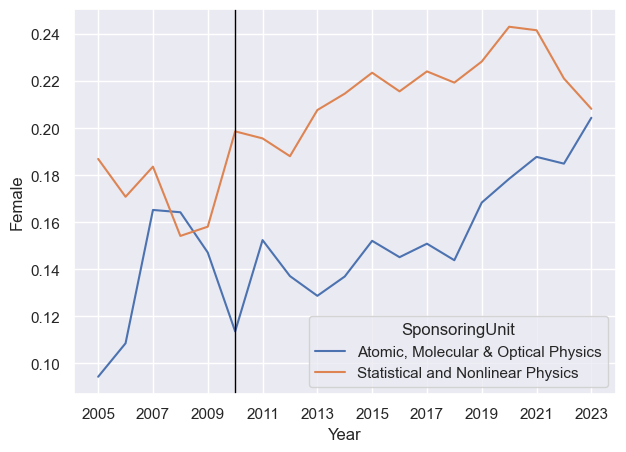

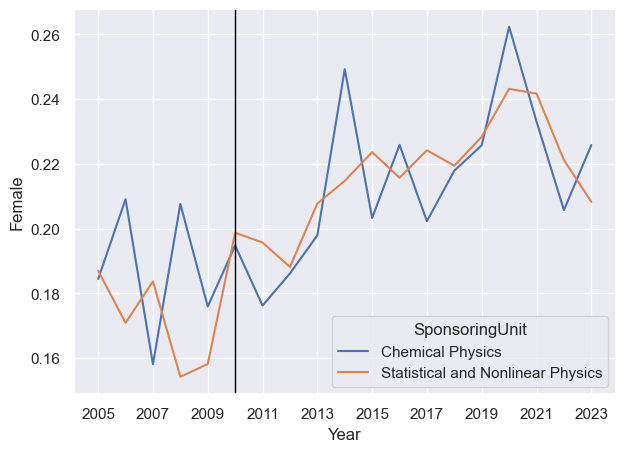

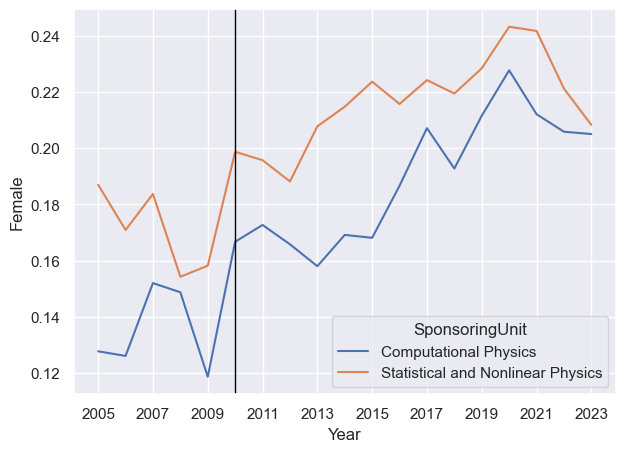

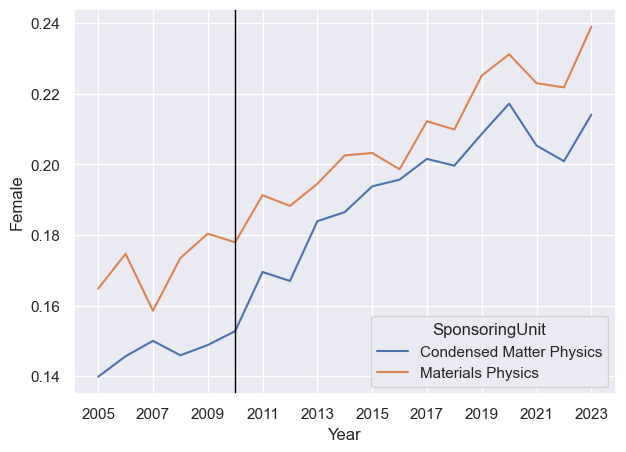

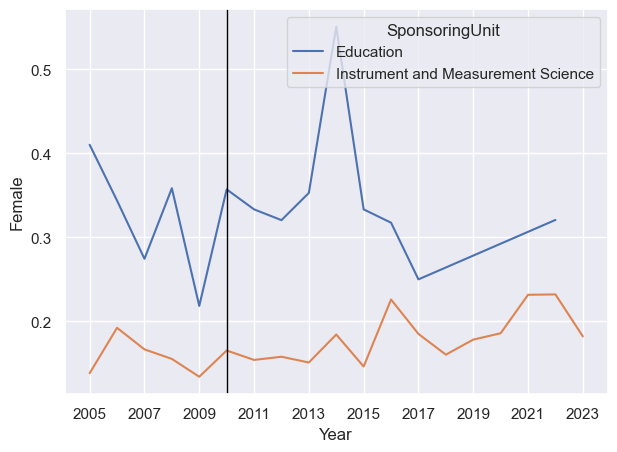

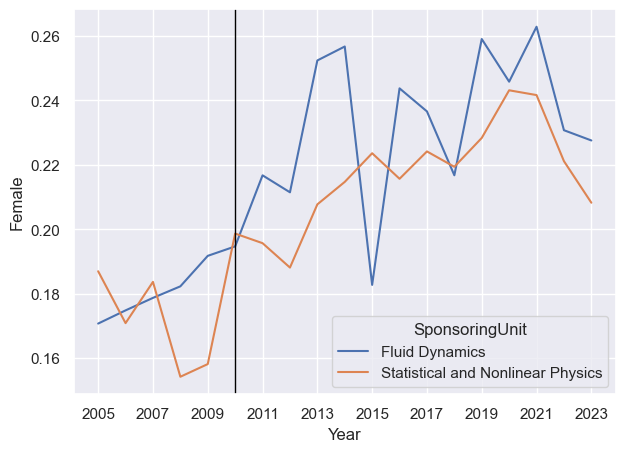

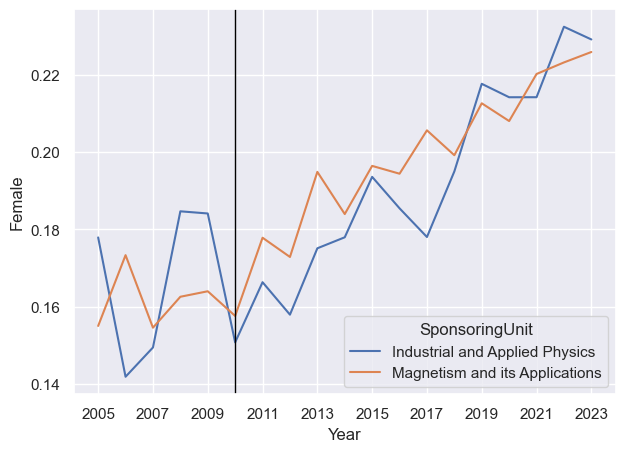

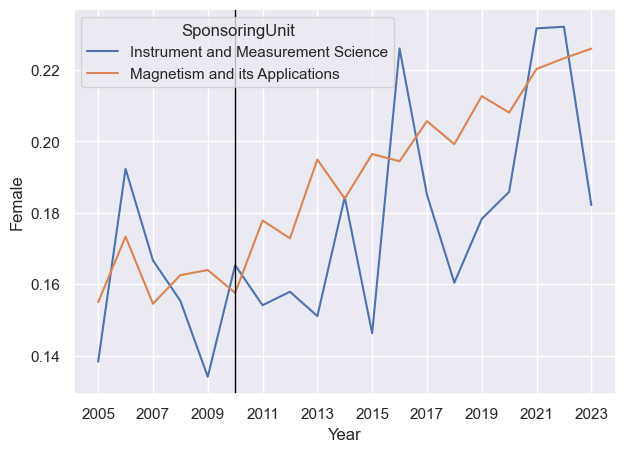

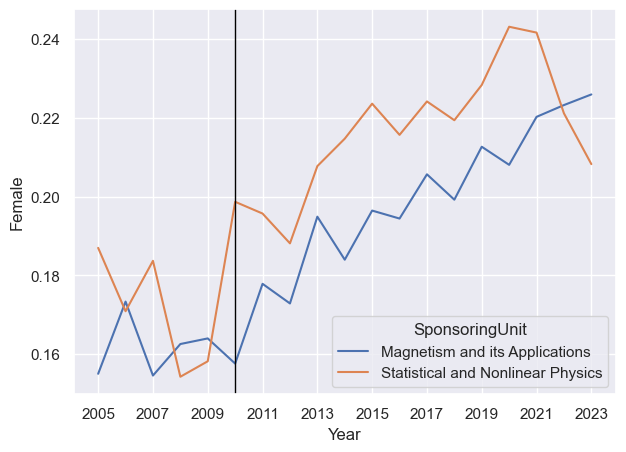

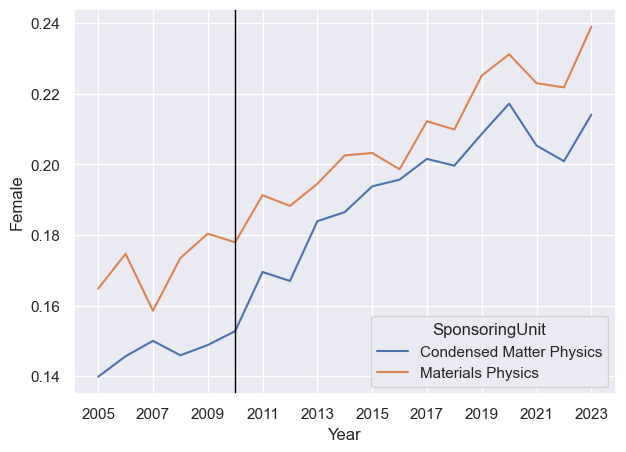

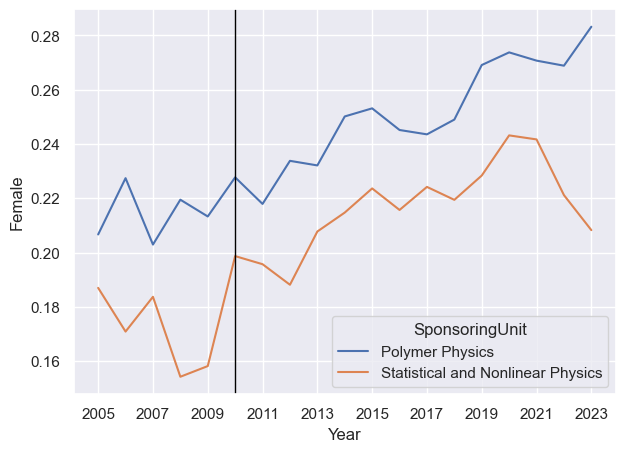

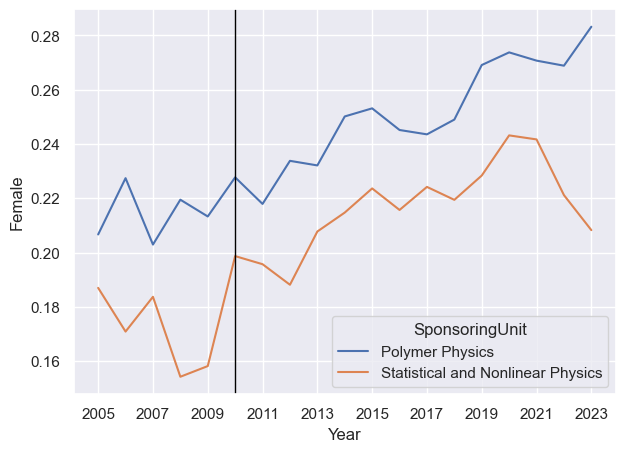

In [66]:
plotNeighbors(neighborMatch, female_df)

In [415]:
#do some kind of filtering, so we do not compare with units with only 3 years ahead